In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Importing data

Please read introduction to MNIST data [here](/en/2022/09/26/knn/#introduction-to-mnist-dataset)

In [2]:
file = '../static/files/large/mnist_train.csv'

In [3]:
df = pd.read_csv(file)

In [4]:
# https://math.stackexchange.com/a/3220477

In [5]:
df.shape

(59999, 785)

In [6]:
df.head(2)

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df.iloc[1,:].max()

255

In [8]:
def data_loader(file):
    df = pd.read_csv(file)
    x = (df.iloc[:, 1:]/255.0).to_numpy()
    y = df.iloc[:, 0].to_numpy()
    return (x, y)

In [9]:
x_train, y_train = data_loader(file)

In [10]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
y_train

array([0, 4, 1, ..., 5, 6, 8])

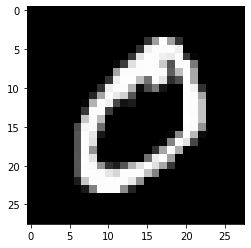

In [12]:
example_to_draw = x_train[0, :].reshape(28,28)
plt.imshow(example_to_draw, cmap='gray')
plt.show()

In [13]:
test_labels = [8, 4]
indices = np.where(np.isin(y_train, test_labels))[0]

x = x_train[indices]
y = y_train[indices]

# 如果数字是 8， 我们把它变成 0
y[y == test_labels[0]] = 0

# 如果数字是 4， 我们把它变成 1
y[y == test_labels[1]] = 1

## Logistic regression

我们现在来看一下我们想干嘛。`x` 是训练数据，`y` 是我们想要的结果。我们来随便看一个例子：

In [14]:
x.shape, y.shape

# 我们总共有 11693 个例子。x 的每一行是一个数字。

((11693, 784), (11693,))

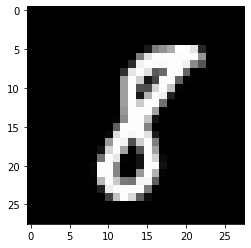

In [38]:
example_to_draw = x[345, :].reshape(28,28)
plt.imshow(example_to_draw, cmap='gray')
plt.show()

# 这是一个 4

我们现在想做的是，我给你一个数字，也就是 x 中的随便一行，你要告诉我这个数字是几。人眼肯定很好识别，但现在我们需要让机器识别数字。

我们注意看。x 的每一行是 784 个像素，每一个像素是一个数值，该数值介于 0 到 1 之间。数值越低，颜色越深。上图中白色部分，数字肯定很高，接近于 1.0。

In [16]:
x[0, :]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

那我们一个很正常的想法是，给每一个像素加权。我们现在要识别的是 8 和 4. 当数字是 8 的时候，我们希望最后算出来的结果是 0。是 4 的时候，我们希望算出来的结果是 1. 

那如果你是机器，你怎么办？考虑到写 4 的时候，我们会在左侧写一个竖，靠右侧又写一个竖。那是不是那几个像素我们给它们比较大的加权，这样算出来的结果就比较大（我们之后会讲到，我们要给数值进行转化。结果越大，我们可以让转化后的结果越接近于 1）。我们写 8 的时候，会在中间上侧画一个弧，中间下侧也有一个弧，那是不是那几个像素我们给它们比较小的加权，这样算出的结果就比较小，也就是越接近于 0。

我们来总结一下，每一个要猜的数字，也就是 x 的其中一行，一共有 784 个数，我们给每一个数一个加权值，设为 w。w 是一个 $784 \times 1$ 的向量。除了 w，我们还需要一个数字，即「偏差」(bias)，这个偏差可以当作阀门一样来对加权运算后的结果进行微调。我们的目标是：没有蛀牙。不对，我们的目标是找到这样的 w 和 b，使得对于 x 的每一行（也就是每一个图像），加权运算与偏差调整之后的结果，也就是 $x_i w + b$，正好是 x 该行所显示的数字。也就是说，我们要让结果要么是 0， 要么是 1. 

然而，现在的问题是，$x_i w + b$，并不一定介于 0 与 1 之间，更不要说结果要么是 0， 要么是 1。怎么办？

逻辑回归要登场了。

我们现在来举个例子。我们知道 $w$ 是一个 $784 \times 1$ 的向量，$b$ 是一个数字。我们给它们初始化一下，随便取值：

In [39]:
m = x.shape[1]

w = np.random.rand(m)
b = np.random.rand()

然后，我们拿上面那个数字 4 来举例：

In [40]:
a = x[345, :]@w + b
a

55.53470099179942

In [41]:
np.exp(-a)

7.613525472933638e-25

In [42]:
a = 1/(1+np.exp(-a))
a

1.0